# Creating, Planting, and Finding Signals Within Noise
Elizabeth Kapelevich

In [3]:
import time
import math
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import signals_and_noise as san

In [2]:
Time1, Position1 = np.loadtxt("mock_data_challenge_1.dat").T
Time2, Position2 = np.loadtxt("mock_data_challenge_2.dat").T

In [17]:
a = 1.5
f = np.linspace(0.01, 10, 20)
sigma = np.linspace(0.01, 1, 50)
t_0 = 2.01
t_start = 2
t_duration = 8
t_max = 20
data_time_series = [Time1, Position1]
data_time_stamps = Time1
del_T_0 = 0.012
del_T = 0.012

In [18]:
search1 = san.frequency_time_sigma_search(del_T_0, t_start, t_max, data_time_series, a, f, sigma, t_duration, del_T)
print(search1)

(1.0, 3.9800000000000018, 6.845263157894737)


In [18]:
a = 1
t_signal_start = 5
t_signal_end = 7
t_noise_start = 0
t_noise_end = 10
del_T = 0.012
del_T_0 = 0.012
t_start = 0
t_max = 10
data_time_series = [times, data]
t_duration = 2
f = np.array([1, 2, 3, 4, 5])
sigma = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

In [20]:
times, C = san.cross_correlation(del_T_0, t_start, t_max, data_time_series, a, f, sigma, t_duration, del_T)

ValueError: operands could not be broadcast together with shapes (5,10000) (5,) 

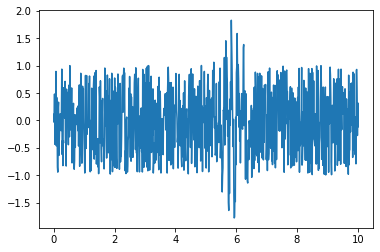

In [11]:
plt.plot(times, data)

In [19]:
a = 1.5
f = np.linspace(0.01, 10, 20)
sigma = np.linspace(0.01, 1, 50)
t_0 = 2.01
t_start = 2
t_duration = 8
t_max = 20
data_time_series = [Time2, Position2]
data_time_stamps = Time2
del_T_0 = 0.012
del_T = 0.012

In [20]:
search2 = san.frequency_time_sigma_search(del_T_0, t_start, t_max, data_time_series, a, f, sigma, t_duration, del_T)
print(search2)

(1.0, 5.815999999999936, 9.47421052631579)
